### Final Code for Sex differences project 

### 1. Prep data set 

In [1]:
%matplotlib inline
import glob
import numpy as np
import random
import pandas as pd
import seaborn as sns; sns.set()
import os
from tqdm import tqdm
from scipy.stats import zscore, norm, pearsonr
import matplotlib.pyplot as plt 

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 
from nilearn import plotting,image 

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from pathlib import Path

from nltools.stats import fdr

from sklearn.metrics import confusion_matrix


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
#import data set
df = pd.read_csv("/home/xlajoie/Desktop/unrestricted_original.csv")

In [3]:
# Filter left-handers (>=50 handedness) 
df = df[df["Handedness"] >= 50].reset_index()


In [4]:
# transform M and F with 0 and 1 

df.rename(columns={"Subject": "subject_label"}, inplace=True)
df["Gender"] = df["Gender"].replace({"M": 0, "F": 1})
df

,index,subject_label,Release,Acquisition,Gender,Age_in_Yrs,Race,Ethnicity,Handedness,Education,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,0,100206,S900,Q11,0,27,White,Not Hispanic/Latino,65,16.0,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,1,100610,S900,Q08,0,27,White,Not Hispanic/Latino,85,16.0,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,2,101006,S500,Q06,1,35,Black or African Am.,Not Hispanic/Latino,90,12.0,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,4,102008,S500,Q06,0,24,White,Hispanic/Latino,80,12.0,...,6.0,122.25,110.45,0.0,50.1,67.48,65.31,1.80,0.0,1.80
4,7,102513,S900,Q10,0,30,White,Not Hispanic/Latino,50,14.0,...,5.2,108.79,98.04,2.0,54.3,84.07,82.37,1.92,0.0,1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,662,990366,S900,Q10,0,22,White,Not Hispanic/Latino,95,15.0,...,4.4,108.79,97.19,1.0,52.6,93.82,92.63,1.80,0.0,1.80
560,663,991267,S500,Q06,0,30,White,Not Hispanic/Latino,75,14.0,...,2.8,122.25,111.41,1.0,46.6,83.23,81.55,1.84,0.0,1.84
561,664,992673,S900,Q12,1,33,White,Not Hispanic/Latino,70,14.0,...,3.6,122.25,111.41,1.0,38.6,101.63,99.26,1.80,0.0,1.80
562,665,993675,S900,Q09,1,29,White,Not Hispanic/Latino,85,16.0,...,0.4,122.25,110.45,0.0,38.6,84.07,84.25,1.80,1.0,1.76


In [6]:
print("hommes = ", df['Gender'].value_counts()[0])
print("femmes = ", df['Gender'].value_counts()[1])

hommes =  263
femmes =  301


In [7]:
#save new csv with modifications as "final hcp database"
df.to_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [8]:
# load dataset containing sex and participant id
df = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [9]:
df["Gender"]  # should have the whole list

0      0
1      0
2      1
3      0
4      0
      ..
559    0
560    0
561    1
562    1
563    1
Name: Gender, Length: 564, dtype: int64

# Atlas Destrieux

#### Bootstrapping

In [13]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker 

def img4d2vector(img_path, masker):
    img_masked = masker.fit_transform(img_path)  #fait une moyenne par label 
    return img_masked.flatten()  #devient 1 vecteur

def vector2img4d(vector, masker):
    data_2d = vector.reshape(8, -1)
    return masker.inverse_transform(data_2d)   #remettre dans espace MNI that we can plot with nilearn

In [14]:
df_boot = pd.read_csv("/home/xlajoie/Desktop/Final_HCP_database.csv")

In [15]:
df_bootstrap = pd.DataFrame()
bootstrap_coef = []

for i in range(0, 4):
    for j in range(0, 200):
    # for j in range(0, len(df_boot)):
        index = random.randint(0, 200-1)
        # index = random.randint(0, len(df_boot)-1)
        frames = [df_bootstrap, df_boot[index:index+1]]
        df_bootstrap = pd.concat(frames)

    df_bootstrap = df_bootstrap.drop(df_bootstrap.columns[0], axis=1)
    df_bootstrap
    
    
    print(df_bootstrap["Gender"])  # should have the whole list
    
    atlas_dest = datasets.fetch_atlas_destrieux_2009()
    masker = NiftiLabelsMasker(atlas_dest.maps)
    
    
    img_tpl = "/data/brambati/dataset/HCP/derivatives/seed-to-voxel-nilearn/results/sub-{0}/sub-{0}_voxelcorrelations.nii.gz"  # à changer
    x_correl = []
    # nb_subjects = len(df_bootstrap)
    nb_subjects = 200
    subject_label = df_bootstrap["subject_label"][:nb_subjects]

    
    for sub in tqdm(subject_label):
        img_path = str(Path(img_tpl.format(sub)))  # format = remplace entre accolades par # sujet
        x_correl.append(img4d2vector(img_path, masker))

    x_correl = np.array(x_correl)
    x_correl.shape  # autant de lignes que de sujets, autant de colones (nb region atlas x 8 (seeds)) 
    
    
    y_sex = df_bootstrap["Gender"][:nb_subjects]  # maybe list(df["Gender"]) 
    
    print(sum(y_sex), len(y_sex))  #double check 
    
    
    # split the sample o training/test with a 80/20 % ratio 
    # and stratify sex by class, also shuffle the data

    X_train, X_test, y_train, y_test = train_test_split( 
                                                        x_correl,  # x 
                                                        y_sex,       # y 
                                                        test_size = 0.2, # 80%/20% split 
                                                        shuffle = True,  #shuffle dataset before splitting
                                                        stratify = y_sex,  # keep distribution of sex_class consistent between train and test sets
                                                        random_state = 123) #same shuffle each time 

    print('train:', len(X_train),'test:', len(X_test))
    
    
    score = []
    model = LinearSVC()
    #score = cross_val_score(model, X_train, y_train, cv=10)
    score.append(cross_val_score(model, X_train, y_train, cv=10, n_jobs = 3).mean())
    print(score)
    
    
    model.fit(X_train,y_train) #fit the model/ train the model
    y_pred = model.predict(X_test)

    #calculate the model accuracy
    acc = model.score(X_test, y_test)

    #compute the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    df_result = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["True", "False"], columns = ["Positive", "Negative"])
    print(df_result.head())

    # print results
    print('accuracy (r2) =', acc)
    
    
    coef = model.coef_[0]
    bootstrap_coef.append(coef)
    
    df_bootstrap = pd.DataFrame()
    score = []

/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


129    1
113    1
8      0
147    0
26     0
      ..
23     0
39     0
137    0
56     1
38     1
Name: Gender, Length: 200, dtype: int64


100%|█████████████████████████████████████████| 200/200 [01:27<00:00,  2.29it/s]

108 200
train: 160 test: 40


[0.8375]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Positive  Negative
True         16         2
False         5        17
accuracy (r2) = 0.825


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


15     1
191    1
98     0
123    0
94     0
      ..
25     1
15     1
176    1
125    1
195    0
Name: Gender, Length: 200, dtype: int64


100%|█████████████████████████████████████████| 200/200 [01:23<00:00,  2.40it/s]


115 200
train: 160 test: 40
[0.8625]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Positive  Negative
True         15         2
False         3        20
accuracy (r2) = 0.875


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


189    1
146    1
157    0
10     1
168    0
      ..
143    0
175    1
82     1
89     0
28     1
Name: Gender, Length: 200, dtype: int64


100%|█████████████████████████████████████████| 200/200 [01:18<00:00,  2.56it/s]


107 200
train: 160 test: 40
[0.8875]


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Positive  Negative
True         19         0
False         3        18
accuracy (r2) = 0.925


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/nilearn/datasets/atlas.py:284: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


37     0
67     1
33     1
87     0
107    1
      ..
180    1
145    0
75     1
38     1
48     1
Name: Gender, Length: 200, dtype: int64


100%|█████████████████████████████████████████| 200/200 [01:20<00:00,  2.48it/s]


96 200
train: 160 test: 40
[0.8]
       Positive  Negative
True         16         5
False         1        18
accuracy (r2) = 0.85


/data/brambati/local/venvs/lingualab_workstation/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [19]:
print("True negative = ",tn)
print("False positive = ", fp)
print("False negative = ", fn)
print("True positive = ", tp)   

True negative =  16
False positive =  5
False negative =  1
True positive =  18


In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
df_result = pd.DataFrame(data=[[tn, fp],[fn,tp]], index= ["(True)Homme", "Femme"], columns = ["(Pred)Homme", "Femme"])
print(df_result.head())

             (Pred)Homme  Femme
(True)Homme           16      5
Femme                  1     18


In [147]:
bootstrap_coef

[array([ 0.00895329,  0.00088375, -0.01803937, ..., -0.01142542,
         0.01155583,  0.07317292]),
 array([-0.00946839, -0.0348718 ,  0.03289062, ..., -0.01223043,
        -0.00848748,  0.00287579]),
 array([-0.00724748, -0.02108557,  0.02701597, ...,  0.03164887,
         0.01297323, -0.01683923]),
 array([ 0.02381671, -0.00163431,  0.05637094, ...,  0.00514037,
        -0.00157829,  0.0482188 ])]

In [151]:
def bootstrap_scores(boot_coefs):
    """
    Calculate z scores and p-value based on bootstrap coefficients
    
    Parameters
    ----------
    boot_coefs: bootstrap coefficients (array-like)
    
    Returns
    ----------
    z_scores: z scores calculated from bootstrap coefficients
    pval: p-value calculated from z-scores
    pval_bonf: corrected p-values using bonferonni correction
    """
    z_scores = np.mean(boot_coefs, axis=0)/np.std(boot_coefs, axis=0)
    assert np.sum(np.isnan(z_scores)) == 0
    pval = 2 * (1 - norm.cdf(np.abs(z_scores)))
    pval_bonf = np.where(pval < (0.05/len(pval)), z_scores, 0)
    boot_z_fdr = np.where(boot_pval < fdr(boot_pval, q=0.05), boot_z, 0)
    
    return z_scores, pval, pval_bonf, boot_z_dr

In [152]:
z_score, pval, pval_bonf = bootstrap_scores(bootstrap_coef)

In [173]:
coef_image = vector2img4d(pval,masker)

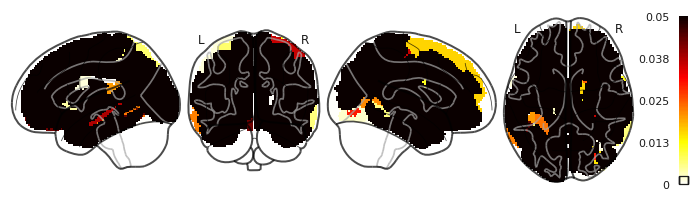

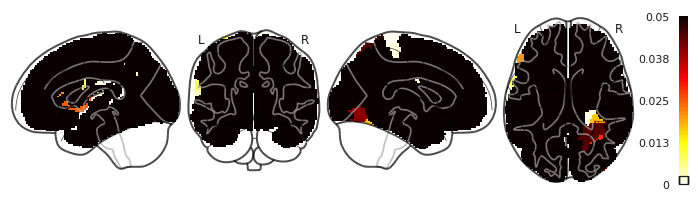

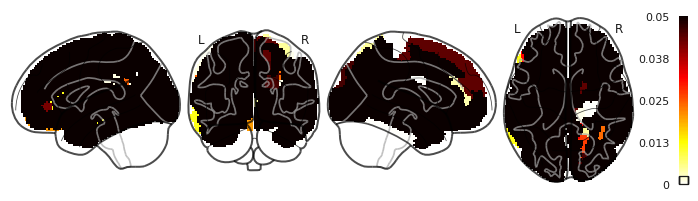

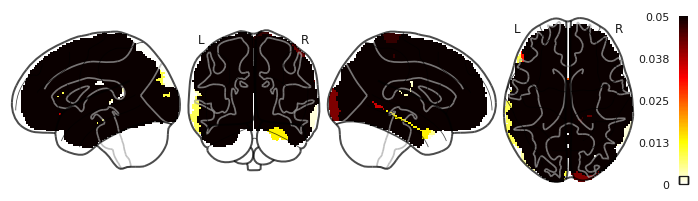

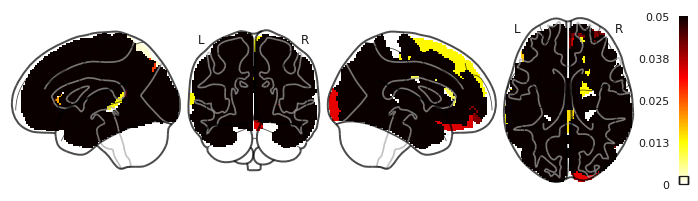

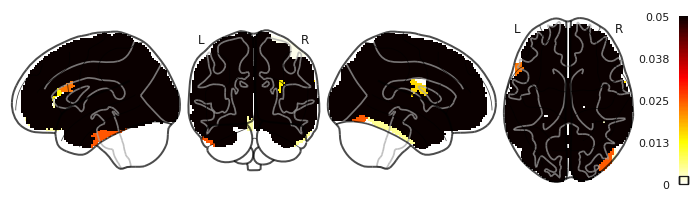

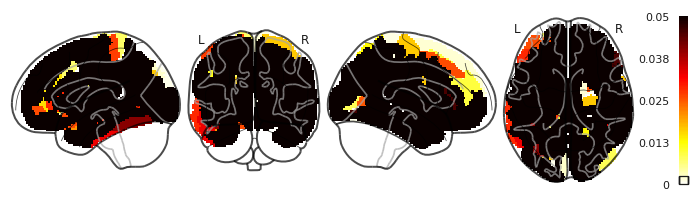

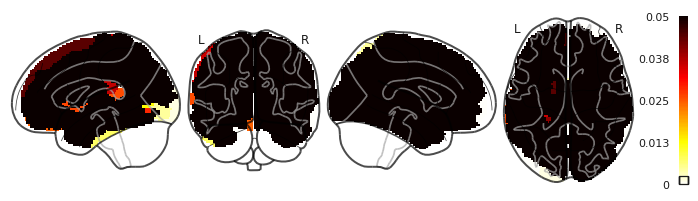

In [174]:
for img in image.iter_img(coef_image):
    # img is now an in-memory 3D img
    plotting.plot_glass_brain(img,display_mode = "lyrz", vmin = 0, vmax = 0.05, colorbar=True)

In [168]:
print(np.count_nonzero(pval < 0.05))
len(pval)

1135


1184

0.0